In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
import copy
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import src.noise.noise_models as nm

from src.circuit import CircuitDAG
import src.ops as ops
from src.backends.density_matrix.compiler import DensityMatrixCompiler
from src.backends.stabilizer.compiler import StabilizerCompiler
from src.metrics import Infidelity

from src.io import IO

In [76]:
def create_circuits(n_emitters, n_photons, d_emitter, lam):
    circs = []
    for s in ("noise", "ideal"):
        circ = CircuitDAG(n_emitter=n_emitters, n_photon=0, n_classical=0)

        for i in range(n_photons):
            circ.add(ops.Identity(register=i, reg_type="p", noise=nm.NoNoise()))

        for i in range(n_emitters):
            # for j in range(d_emitter):
            for j in range(n_photons):
                circ.add(ops.Hadamard(register=i, reg_type="e", noise=nm.NoNoise() if s=="ideal" else nm.DepolarizingNoise(depolarizing_prob=lam)))
                circ.add(ops.CNOT(control=i, control_type="e", target=j, target_type="p", noise=nm.NoNoise()))


        circs.append(circ)
    return circs


In [89]:
run = []
for n_emitters in (1,):
    for d_emitter in (1,):  #, 4, 5, 6, 7):
        for n_photons in (1, 2, 3, 4, 5, 6, 7, 8, 9):
            for lam in (0.5,): #np.linspace(0.0, 1.0, 5):
                for compiler in [
                    DensityMatrixCompiler(),
                    StabilizerCompiler()
                ]:
                    # for reduce in (True, False):
                    for reduce in (True,):
                        nm.REDUCE_STABILIZER_MIXTURE = reduce

                        circ, circ_ideal = create_circuits(n_emitters, n_photons, d_emitter, lam)

                        t0 = time.time()
                        state_ideal = compiler.compile(circ_ideal)
                        metric = Infidelity(target=state_ideal)
                        state = compiler.compile(circ)

                        infidelity = metric.evaluate(state=state, circuit=None)
                        t = time.time() - t0
                        print(t)
                        d = dict(
                            lam=lam,
                            # total_prob=state.stabilizer.probability,
                            compiler=compiler.__class__.__name__,
                            infidelity=infidelity,
                            time=t,
                            reduce=reduce,
                            n_emitters=n_emitters,
                            n_photons=n_photons,
                            d_emitter=d_emitter,
                            n_tableaus=len(state.stabilizer.mixture) if compiler.__class__ == StabilizerCompiler else np.nan,
                        )
                        print(d)
                        run.append(d)

df = pd.DataFrame(run)


0.0029921531677246094
{'lam': 0.5, 'compiler': 'DensityMatrixCompiler', 'infidelity': 0.3333333333333335, 'time': 0.0029921531677246094, 'reduce': True, 'n_emitters': 1, 'n_photons': 1, 'd_emitter': 1, 'n_tableaus': nan}
0.003991603851318359
{'lam': 0.5, 'compiler': 'StabilizerCompiler', 'infidelity': 0.33333333333333337, 'time': 0.003991603851318359, 'reduce': True, 'n_emitters': 1, 'n_photons': 1, 'd_emitter': 1, 'n_tableaus': 4}
0.0029916763305664062
{'lam': 0.5, 'compiler': 'DensityMatrixCompiler', 'infidelity': 0.6111111111111113, 'time': 0.0029916763305664062, 'reduce': True, 'n_emitters': 1, 'n_photons': 2, 'd_emitter': 1, 'n_tableaus': nan}
0.009979009628295898
{'lam': 0.5, 'compiler': 'StabilizerCompiler', 'infidelity': 0.6111111111111112, 'time': 0.009979009628295898, 'reduce': True, 'n_emitters': 1, 'n_photons': 2, 'd_emitter': 1, 'n_tableaus': 8}
0.00399017333984375
{'lam': 0.5, 'compiler': 'DensityMatrixCompiler', 'infidelity': 0.7777777777777779, 'time': 0.003990173339843

In [84]:
df

,lam,compiler,infidelity,time,reduce,n_emitters,n_photons,d_emitter,n_tableaus
0,0.5,DensityMatrixCompiler,0.555556,0.003990,True,2,1,1,NaN
1,0.5,StabilizerCompiler,0.555556,0.017951,True,2,1,1,16.0
2,0.5,DensityMatrixCompiler,0.820988,0.006173,True,2,2,1,NaN
3,0.5,StabilizerCompiler,0.820988,0.099319,True,2,2,1,34.0
4,0.5,DensityMatrixCompiler,0.917695,0.041610,True,2,3,1,NaN
5,0.5,StabilizerCompiler,0.917695,0.433522,True,2,3,1,68.0
6,0.5,DensityMatrixCompiler,0.961210,0.081431,True,2,4,1,NaN
7,0.5,StabilizerCompiler,0.961210,1.626876,True,2,4,1,136.0


   lam  infidelity       time  reduce  n_emitters  n_photons  d_emitter  \
0  0.5    0.555556   0.032476    True           2          1          1   
1  0.5    0.820988   0.208851    True           2          2          1   
2  0.5    0.917695   0.387375    True           2          3          1   
3  0.5    0.961210   0.906207    True           2          4          1   
4  0.5    0.980863   3.642675    True           2          5          1   
5  0.5    0.990482  10.114166    True           2          6          1   
6  0.5    0.995208  38.649554    True           2          7          1   

   n_tableaus  
0          16  
1          34  
2          68  
3         136  
4         272  
5         544  
6        1088  


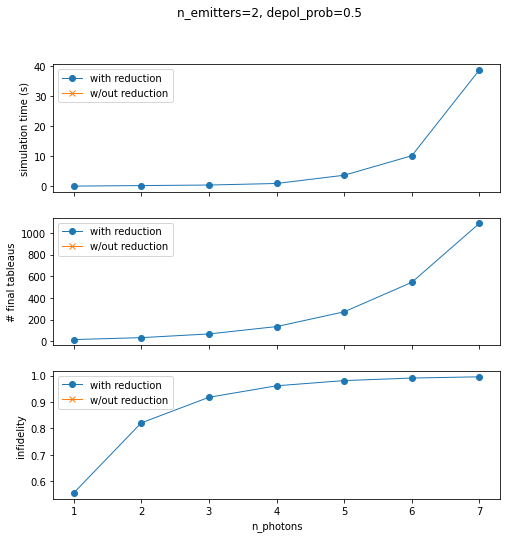

06/10/2022, 09:59:20 | Saved figure to C:\Users\benma\OneDrive - University of Waterloo\Backups\Desktop (BACKUP)\1 - Projects\AF Inverse Graph Design\graph-compiler\data\2022-10-06_mixed_stabilizer_reduction\n_emitters=2, depol_prob=0.5.png successfully.


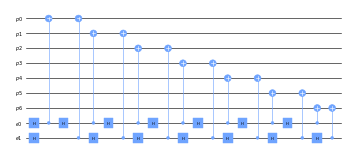

06/10/2022, 09:59:21 | Saved figure to C:\Users\benma\OneDrive - University of Waterloo\Backups\Desktop (BACKUP)\1 - Projects\AF Inverse Graph Design\graph-compiler\data\2022-10-06_mixed_stabilizer_reduction\n_emitters=2, depol_prob=0.5_qasm.png successfully.


In [80]:
io = IO.new_directory(folder="mixed_stabilizer_reduction", include_date=True)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=[8,8])

save = False
n_emitters, d_emitter, lam = 2, 1, 0.5
reduce_ls = dict(lw=1.0, ls='-', marker='o')
naive_ls = dict(lw=1.0, ls='-', marker='x')

df0 = df[(df["n_emitters"] == n_emitters) & (df["d_emitter"] == d_emitter) & (df["lam"] == lam)]
print(df0)

dfj = df0[df0["reduce"] == True]
axs[0].plot(dfj.n_photons, dfj.time, label="with reduction", **reduce_ls)
axs[1].plot(dfj.n_photons, dfj.n_tableaus, label="with reduction", **reduce_ls)
axs[2].plot(dfj.n_photons, dfj.infidelity, label="with reduction", **reduce_ls)

dfj = df0[df0["reduce"] == False]
axs[0].plot(dfj.n_photons, dfj.time, label="w/out reduction", **naive_ls)
axs[1].plot(dfj.n_photons, dfj.n_tableaus, label="w/out reduction", **naive_ls)
axs[2].plot(dfj.n_photons, dfj.infidelity, label="w/out reduction", **naive_ls)

axs[0].set(ylabel="simulation time (s)")
axs[1].set(ylabel="# final tableaus")
axs[2].set(ylabel="infidelity")
axs[-1].set(xlabel="n_photons")

for ax in axs:
    ax.legend()

name = f"n_emitters={n_emitters}_depol_prob={lam}"

fig.suptitle(name)
plt.show()

qasm, _ = circ.draw_circuit()

if save:
    io.save_figure(fig, filename=f"{name}.png")
    io.save_figure(qasm, filename=f"{name}_qasm.png")

    lam               compiler  infidelity       time  reduce  n_emitters  \
0   0.5  DensityMatrixCompiler    0.333333   0.002992    True           1   
1   0.5     StabilizerCompiler    0.333333   0.003992    True           1   
2   0.5  DensityMatrixCompiler    0.611111   0.002992    True           1   
3   0.5     StabilizerCompiler    0.611111   0.009979    True           1   
4   0.5  DensityMatrixCompiler    0.777778   0.003990    True           1   
5   0.5     StabilizerCompiler    0.777778   0.029357    True           1   
6   0.5  DensityMatrixCompiler    0.873457   0.009647    True           1   
7   0.5     StabilizerCompiler    0.873457   0.101485    True           1   
8   0.5  DensityMatrixCompiler    0.927984   0.067836    True           1   
9   0.5     StabilizerCompiler    0.927984   0.301534    True           1   
10  0.5  DensityMatrixCompiler    0.959019   0.087386    True           1   
11  0.5     StabilizerCompiler    0.959019   0.773196    True           1   

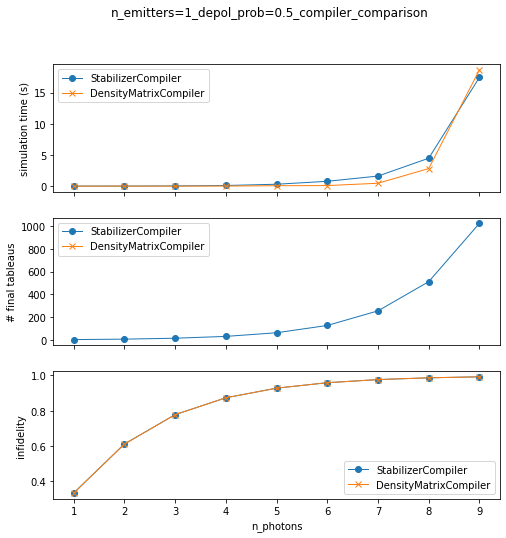

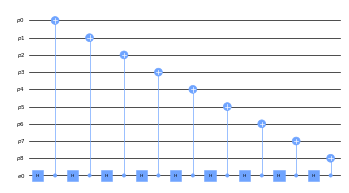

06/10/2022, 10:09:01 | Saved figure to C:\Users\benma\OneDrive - University of Waterloo\Backups\Desktop (BACKUP)\1 - Projects\AF Inverse Graph Design\graph-compiler\data\2022-10-06_mixed_stabilizer_reduction\n_emitters=1_depol_prob=0.5_compiler_comparison.png successfully.
06/10/2022, 10:09:01 | Saved figure to C:\Users\benma\OneDrive - University of Waterloo\Backups\Desktop (BACKUP)\1 - Projects\AF Inverse Graph Design\graph-compiler\data\2022-10-06_mixed_stabilizer_reduction\n_emitters=1_depol_prob=0.5_compiler_comparison_qasm.png successfully.


In [91]:
io = IO.new_directory(folder="mixed_stabilizer_reduction", include_date=True)
fig, axs = plt.subplots(3, 1, sharex=True, figsize=[8,8])

save = True
n_emitters, d_emitter, lam = 1, 1, 0.5
stab_ls = dict(lw=1.0, ls='-', marker='o')
dm_ls = dict(lw=1.0, ls='-', marker='x')

df0 = df[(df["n_emitters"] == n_emitters) & (df["d_emitter"] == d_emitter) & (df["lam"] == lam) & (df["reduce"] == True)]
print(df0)

dfj = df0[df0["compiler"] == "StabilizerCompiler"]
axs[0].plot(dfj.n_photons, dfj.time, label="StabilizerCompiler", **stab_ls)
axs[1].plot(dfj.n_photons, dfj.n_tableaus, label="StabilizerCompiler", **stab_ls)
axs[2].plot(dfj.n_photons, dfj.infidelity, label="StabilizerCompiler", **stab_ls)

dfj = df0[df0["compiler"] == "DensityMatrixCompiler"]
axs[0].plot(dfj.n_photons, dfj.time, label="DensityMatrixCompiler", **dm_ls)
axs[1].plot(dfj.n_photons, dfj.n_tableaus, label="DensityMatrixCompiler", **dm_ls)
axs[2].plot(dfj.n_photons, dfj.infidelity, label="DensityMatrixCompiler", **dm_ls)

axs[0].set(ylabel="simulation time (s)")
axs[1].set(ylabel="# final tableaus")
axs[2].set(ylabel="infidelity")
axs[-1].set(xlabel="n_photons")

for ax in axs:
    ax.legend()

name = f"n_emitters={n_emitters}_depol_prob={lam}_compiler_comparison"

fig.suptitle(name)
plt.show()

qasm, _ = circ.draw_circuit()

if save:
    io.save_figure(fig, filename=f"{name}.png")
    io.save_figure(qasm, filename=f"{name}_qasm.png")